In [1]:
#!pip install tensorflow pandas sklearn numpy

## Goals

 - Loading the frames generated by our `simulator.py`
     - TODO: Generate Realtime System Simulations with different behaviours (No, Medium or Strong Perturbations)
     - TODO: Label the frames correctly
 - Preprocess the frames
 - Select a first model for experimentation purposes (TensorFlow)
 - Train the model on the loaded frames
 - Analyze the model performance on newly generated frames
 - Adjust either the model or the simulator and repeat all the steps above.

In [2]:
import tensorflow as tf

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

In [5]:
tf.__version__

'1.15.0'

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_dir = os.path.join(".", 'frames', 'train')
validation_dir = os.path.join(".", 'frames', 'valid')

In [8]:
train_stable_dir = os.path.join(train_dir, 'stable')
train_malfunction_dir = os.path.join(train_dir, 'malfunction')

validation_stable_dir = os.path.join(validation_dir, 'stable')
validation_malfunction_dir = os.path.join(validation_dir, 'malfunction')

In [9]:
train_stable_num = len(os.listdir(train_stable_dir))
train_malfunction_num = len(os.listdir(train_malfunction_dir))

validation_stable_num = len(os.listdir(validation_stable_dir))
validation_malfunction_num = len(os.listdir(validation_malfunction_dir))

total_train = train_stable_num + train_malfunction_num
total_validation = validation_stable_num + validation_malfunction_num

In [10]:
print('total training stable images:', train_stable_num)
print('total training malfunction images:', train_malfunction_num)
print('--')
print('total validation stable images:', validation_stable_num)
print('total validation malfunction images:', validation_malfunction_num)
print("----")
print("Total training images:", total_train)
print("Total validation images:", total_validation)

total training stable images: 1100
total training malfunction images: 1101
--
total validation stable images: 1100
total validation malfunction images: 1101
----
Total training images: 2201
Total validation images: 2201


In [11]:
batch_size = 8
epochs = 100
IMG_HEIGHT = 250
IMG_WIDTH = 250

In [12]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
validation_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=validation_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2200 images belonging to 2 classes.
Found 2200 images belonging to 2 classes.


In [14]:
model = Sequential([
    Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0

In [17]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_validation // batch_size,
    epochs=epochs,
    validation_data=validation_data_gen,
    validation_steps=total_train // batch_size
)

ss: 4.3529 - val_acc: 0.7077
Epoch 39/100
275/275 [==============================] - 45s 162ms/step - loss: 1.5794e-07 - acc: 1.0000 - val_loss: 4.3797 - val_acc: 0.7077
Epoch 40/100
275/275 [==============================] - 44s 159ms/step - loss: 1.2986e-07 - acc: 1.0000 - val_loss: 4.4116 - val_acc: 0.7077
Epoch 41/100
275/275 [==============================] - 44s 159ms/step - loss: 1.1252e-07 - acc: 1.0000 - val_loss: 4.5051 - val_acc: 0.7068
Epoch 42/100
275/275 [==============================] - 43s 155ms/step - loss: 9.4406e-08 - acc: 1.0000 - val_loss: 4.5123 - val_acc: 0.7073
Epoch 43/100
275/275 [==============================] - 41s 150ms/step - loss: 7.6343e-08 - acc: 1.0000 - val_loss: 4.5402 - val_acc: 0.7077
Epoch 44/100
275/275 [==============================] - 44s 159ms/step - loss: 7.1624e-08 - acc: 1.0000 - val_loss: 4.5649 - val_acc: 0.7086
Epoch 45/100
275/275 [==============================] - 44s 158ms/step - loss: 6.2765e-08 - acc: 1.0000 - val_loss: 4.6296 - 

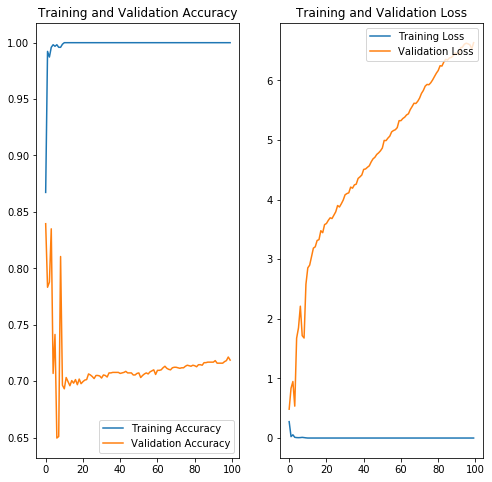

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
import pandas as pd

In [21]:
pd.DataFrame(history.history).to_csv("naive_approach_data.csv", index=False)